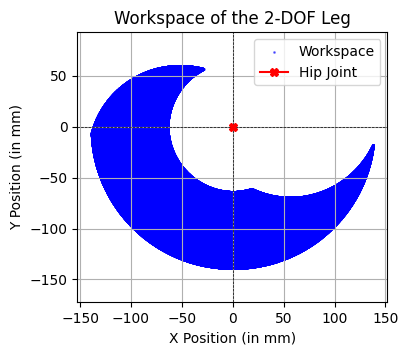

In [59]:
L1 = 60
L2 = 90
theta1_range = [-150, 20]
theta2_range = [-45, -135]
resolution=1000

# Generate angle ranges
theta1 = np.linspace(np.radians(theta1_range[0]), np.radians(theta1_range[1]), resolution)
theta2 = np.linspace(np.radians(theta2_range[0]), np.radians(theta2_range[1]), resolution)

# Initialize arrays for workspace points
x_points = []
y_points = []

# Compute workspace points
for t1 in theta1:
    for t2 in theta2:
        # Forward kinematics for 2-DOF leg
        x = L1 * np.cos(t1) + L2 * np.cos(t1 + t2)
        y = L1 * np.sin(t1) + L2 * np.sin(t1 + t2)
        
        x_points.append(x)
        y_points.append(y)

# Plot workspace
plt.figure(figsize=(4, 3.5))
plt.scatter(x_points, y_points, s=1, color='blue', alpha=0.5, label="Workspace")
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.plot(0,0,marker = "X", color="red", label="Hip Joint")
plt.legend()
plt.title("Workspace of the 2-DOF Leg")
plt.xlabel("X Position (in mm)")
plt.ylabel("Y Position (in mm)")
plt.axis("equal")
plt.grid(True)
plt.savefig("Workspace.png", dpi=300, bbox_inches='tight')
plt.show()

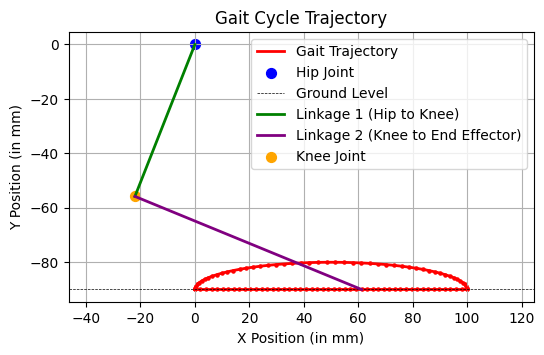

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
L1 = 60  # Length of the first linkage
L2 = 90  # Length of the second linkage

# Gait cycle parameters
a = 50  # Semi-major axis of the ellipse (forward/backward motion range)
b = 10  # Semi-minor axis of the ellipse (vertical swing height)
center_x = 50  # Center of the swing phase in x
ground_level = -90  # Y position of ground
stance_fraction = 0.5  # Fraction of the cycle spent in the stance phase
steps = 100  # Total number of points in the gait cycle

# Generate trajectory for the stance and swing phases
t = np.linspace(0, 2 * np.pi, steps)
x_traj = np.zeros(steps)
y_traj = np.zeros(steps)

# Stance phase (flat portion)
stance_steps = int(steps * stance_fraction)
swing_steps = steps - stance_steps

x_traj[:stance_steps] = np.linspace(center_x - a, center_x + a, stance_steps)
y_traj[:stance_steps] = ground_level

# Swing phase (elliptical arc)
swing_t = np.linspace(0, np.pi, swing_steps)
x_traj[stance_steps:] = center_x + a * np.cos(swing_t)
y_traj[stance_steps:] = ground_level + b * np.sin(swing_t)

# Initialize arrays for joint angles
theta1_traj = []
theta2_traj = []

# Calculate joint angles for the trajectory using inverse kinematics
for x, y in zip(x_traj, y_traj):
    # Inverse kinematics for a 2-DOF leg
    r = np.sqrt(x**2 + y**2)  # Distance to the point
    phi = np.arctan2(y, x)  # Angle to the point

    # Check if the point is reachable
    if r > (L1 + L2) or r < abs(L1 - L2):
        raise ValueError(f"Point ({x}, {y}) is outside the reachable workspace.")

    # Law of cosines
    cos_theta2 = (r**2 - L1**2 - L2**2) / (2 * L1 * L2)
    theta2 = np.arccos(cos_theta2)  # Knee angle
    theta1 = phi - np.arctan2(L2 * np.sin(theta2), L1 + L2 * np.cos(theta2))  # Hip angle

    theta1_traj.append(theta1)
    theta2_traj.append(theta2)

# Forward kinematics to plot the trajectory in the workspace
x_fk = []
y_fk = []
knee_positions = []  # Store knee positions for visualization
for t1, t2 in zip(theta1_traj, theta2_traj):
    knee_x = L1 * np.cos(t1)
    knee_y = L1 * np.sin(t1)
    x = knee_x + L2 * np.cos(t1 + t2)
    y = knee_y + L2 * np.sin(t1 + t2)
    x_fk.append(x)
    y_fk.append(y)
    knee_positions.append((knee_x, knee_y))

# Plot the trajectory
plt.figure(figsize=(6, 3.5))
plt.plot(x_fk, y_fk, color='red', linewidth=2, label="Gait Trajectory")
plt.scatter(x_fk, y_fk, color='red', s=5)
plt.scatter(0, 0, color='blue', s=50, label="Hip Joint")
plt.axhline(ground_level, color='black', linewidth=0.5, linestyle='--', label="Ground Level")

# Show one example linkage configuration
example_index = 30  # Index of the point to illustrate the linkage
knee_x, knee_y = knee_positions[example_index]
end_x, end_y = x_fk[example_index], y_fk[example_index]
plt.plot([0, knee_x], [0, knee_y], color='green', linewidth=2, label="Linkage 1 (Hip to Knee)")
plt.plot([knee_x, end_x], [knee_y, end_y], color='purple', linewidth=2, label="Linkage 2 (Knee to End Effector)")
plt.scatter(knee_x, knee_y, color='orange', s=50, label="Knee Joint")

# Formatting and legend placement
plt.xlabel("X Position (in mm)")
plt.ylabel("Y Position (in mm)")
plt.legend(loc='upper right')  # Legend in the top-right corner
plt.grid(True)
plt.axis("equal")
plt.title("Gait Cycle Trajectory")
plt.savefig("Gait_Trajectory.png", dpi=300, bbox_inches='tight')
plt.show()

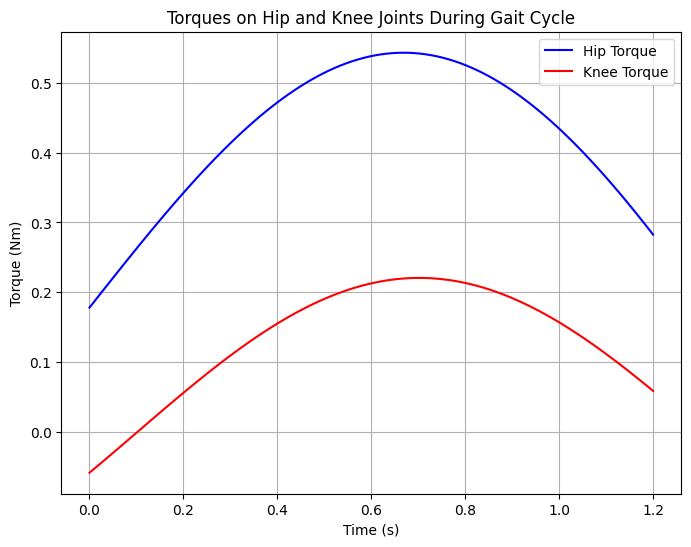

In [61]:
import numpy as np
import sympy as sp

# Define symbolic variables
t = sp.symbols('t')  # Time
theta1 = sp.Function('theta1')(t)  # Hip joint angle
theta2 = sp.Function('theta2')(t)  # Knee joint angle

# Define constants
L1, L2 = sp.symbols('L1 L2')  # Link lengths
m1, m2 = sp.symbols('m1 m2')  # Link masses
I1, I2 = sp.symbols('I1 I2')  # Moments of inertia
g = sp.symbols('g')  # Gravitational acceleration

# Define angular velocities
theta1_dot = sp.diff(theta1, t)
theta2_dot = sp.diff(theta2, t)

# Position of the center of mass of each link
x1 = (L1 / 2) * sp.cos(theta1)
y1 = (L1 / 2) * sp.sin(theta1)
x2 = L1 * sp.cos(theta1) + (L2 / 2) * sp.cos(theta1 + theta2)
y2 = L1 * sp.sin(theta1) + (L2 / 2) * sp.sin(theta1 + theta2)

# Velocities of the center of mass
v1_x = sp.diff(x1, t)
v1_y = sp.diff(y1, t)
v2_x = sp.diff(x2, t)
v2_y = sp.diff(y2, t)

# Kinetic energy (translational + rotational)
T1 = (1 / 2) * m1 * (v1_x**2 + v1_y**2) + (1 / 2) * I1 * theta1_dot**2
T2 = (1 / 2) * m2 * (v2_x**2 + v2_y**2) + (1 / 2) * I2 * (theta1_dot + theta2_dot)**2
T = T1 + T2

# Potential energy
V1 = m1 * g * y1
V2 = m2 * g * y2
V = V1 + V2

# Lagrangian
L = T - V

# Generalized equations of motion (Euler-Lagrange)
torque1 = sp.diff(sp.diff(L, theta1_dot), t) - sp.diff(L, theta1)
torque2 = sp.diff(sp.diff(L, theta2_dot), t) - sp.diff(L, theta2)

# Simplify the torques
torque1 = sp.simplify(torque1)
torque2 = sp.simplify(torque2)

# Numerical parameters
params = {
    L1: 0.060,  # Length of first linkage (mm)
    L2: 0.090,  # Length of second linkage (mm)
    m1: 0.1,  # Mass of first link (kg)
    m2: 0.5,  # Mass of second link (kg) + Mass of robot/4
    I1: (1/12) * 1.0 * 60**2,  # Moment of inertia of first link
    I2: (1/12) * 1.5 * 90**2,  # Moment of inertia of second link
    g: 9.81  # Gravitational acceleration (m/s^2)
}

# Gait cycle information
gait_duration = 1.2  # Total time for the gait cycle (s)
steps = 100  # Number of points in the gait cycle
time = np.linspace(0, gait_duration, steps)  # Time points

# Angles from gait trajectory (already calculated previously)
theta1_values = np.linspace(-np.pi/4, np.pi/4, steps)  # Example theta1 values
theta2_values = np.linspace(-np.pi/3, np.pi/6, steps)  # Example theta2 values

# Calculate angular velocities and accelerations (finite differences)
theta1_dot_values = np.gradient(theta1_values, time)
theta2_dot_values = np.gradient(theta2_values, time)
theta1_ddot_values = np.gradient(theta1_dot_values, time)
theta2_ddot_values = np.gradient(theta2_dot_values, time)

# Compute torques numerically for each time step
torque1_values = []
torque2_values = []

for i in range(steps):
    subs = {
        theta1: theta1_values[i],
        theta2: theta2_values[i],
        sp.diff(theta1, t): theta1_dot_values[i],
        sp.diff(theta2, t): theta2_dot_values[i],
        sp.diff(theta1, t, t): theta1_ddot_values[i],
        sp.diff(theta2, t, t): theta2_ddot_values[i]
    }
    # Substitute parameters and numerical values
    torque1_numeric = torque1.subs(subs).subs(params).evalf()
    torque2_numeric = torque2.subs(subs).subs(params).evalf()
    
    torque1_values.append(torque1_numeric)
    torque2_values.append(torque2_numeric)

# Plot torques
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(time, torque1_values, label="Hip Torque", color="blue")
plt.plot(time, torque2_values, label="Knee Torque", color="red")
plt.xlabel("Time (s)")
plt.ylabel("Torque (Nm)")
plt.title("Torques on Hip and Knee Joints During Gait Cycle")
plt.legend()
plt.grid(True)
plt.savefig("Torque_over_GaitCycle.png", dpi=300, bbox_inches='tight')
plt.show()
